In [111]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn import svm
import re

In [112]:
def get_params_specs(spec_hr_file):
    spec_hr_file = Path(spec_hr_file)
    if not spec_hr_file.is_file():
        raise FileNotFoundError(
            "Human readable file not found: {}".format(spec_hr_file)
        )
    params = pd.read_csv(spec_hr_file, delim_whitespace=True, nrows=1)
    specs = pd.read_csv(
        spec_hr_file, skiprows=3, delim_whitespace=True, header=None
    )
    n_sites = params.n_sites[0]
    n_fils = params.n_filaments[0]
    fil_labels = [
        i
        for sub in [
            ["fil{:03d}".format(i)] * 3 * n_sites for i in range(n_fils)
        ]
        for i in sub
    ]
    site_labels = [
        i
        for sub in [
            ["site{:03d}".format(i)] * 3 for i in range(n_sites)
        ] * n_fils
        for i in sub
    ]
    arrays = [fil_labels, site_labels, ["x", "y", "z"] * n_sites * n_fils]
    columns = pd.MultiIndex.from_arrays(
        arrays, names=["filament", "site", "coord"]
    )
    specs.columns = columns
    specs.index.name = "time"
    return params, specs

def rename_spiral_files(path_to_files):
    substring_to_replace = "v[0-9]+"
    replacement = "lp{:05.1f}_dr{:05.2f}"
    formatter_contents = ['filament:perlen_ratio', 'filament:driving_factor']
    renamer = FileRenamer(substring_to_replace, replacement, formatter_contents)
    yaml_files = sorted(list(Path(path_to_files).glob('*params.yaml')))
    for file in yaml_files:
        renamer.rename(file, confirm=False)

In [3]:
# from simcore_tools import FileRenamer
# rename_spiral_files()

In [30]:
spec_hr_files = sorted(list(Path('./data/spiral_results/').glob('*.spec.hr')))

In [88]:
stability = []
for file in spec_hr_files:
    params, specs = get_params_specs(file)
    dr = re.search('dr[0-9.]+', file.name)[0][2:]
    lp = re.search('lp[0-9.]+', file.name)[0][2:]
    is_stable = specs.shape[0] == 5000
    stability.append([dr, lp, is_stable])

In [89]:
stability = np.array(stability)
np.save("spiral_stability_parameters")

In [308]:
X = stability[:, :2][:, ::-1].astype(float)
y = np.array([0 if i == 'True' else 1 for i in stability[:, 2]])

In [316]:
clf = svm.LinearSVC(tol=0.01, fit_intercept=False)
clf.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)

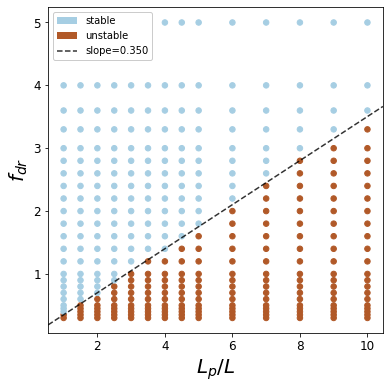

In [318]:
plt.figure(figsize=(6, 6))
sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

proxy = [plt.Rectangle((0, 0), 1, 1, fc=pc) for pc in [plt.cm.Paired(0.0), plt.cm.Paired(1.0)]]
proxy.append(plt.Line2D((0, 0), (1, 1), color='k', linestyle='dashed', alpha=0.8))

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.8,
           linestyles=['--'])
#k = ax.legend()
plt.legend(proxy, 
           ["stable", "unstable", "slope={:0.3f}".format(-clf.coef_[0, 0]/clf.coef_[0, 1])],
          loc='upper left', framealpha=1)

#ax.legend(['fail', 'succeed', 'coef = {:.03f}'.format(-clf.coef_[0, 0]/clf.coef_[0, 1])], loc='best')

# plot support vectors
#ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
#           linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel("$L_p/L$", fontsize=20)
plt.ylabel("$f_{dr}$", fontsize=20)
plt.tick_params(labelsize=12)
plt.savefig("spool_decision_boundary.png", dpi=600)

In [727]:
def calc_spiral_data(params, specs, failure_cutoff):
    t = specs.shape[0]
    dr = float(re.search('dr[0-9.]+', file.name)[0][2:])
    length = params.length[0]
    delta = 0.5 * params.delta[0] * params.n_spec[0]
    lifetime = delta * t
    if t < failure_cutoff:
        return np.array([dr,
                     length, 
                     params.persistence_length[0],
                     lifetime,
                     0, 
                     0, 
                     0, 
                     0])
    xt = specs['fil000']['site000']['x']
    yt = specs['fil000']['site000']['y']
    xh = specs['fil000']['site036']['x']
    yh = specs['fil000']['site036']['y']
    xh = xh[-t//5:]
    yh = yh[-t//5:]
    padding = int(2**17)
    yf = np.fft.fft(xh, n=padding)
    xf = np.fft.fftfreq(padding, d=delta)
    freq = xf[np.argmax(2.0/padding * np.abs(yf[0:padding // 2]))]
    omega = freq * 2 * np.pi
    rhead = np.array([xh, yh]).transpose()
    radius_head = np.sqrt(np.sum(rhead**2, axis=1).mean())
    rtail = np.array([xt, yt]).transpose()
    radius_tail = np.sqrt(np.sum(rtail**2, axis=1).mean())
    avg_radius = 0.5 * (radius_head + radius_tail)
    friction_par = 2.0 * length / (3.0 * np.log(length))
    theory = 1.0/friction_par * dr * length / avg_radius
    return np.array([dr,
                     length, 
                     params.persistence_length[0],
                     lifetime,
                     omega, 
                     theory, 
                     radius_head, 
                     radius_tail])

In [728]:
data = []
for file in spec_hr_files:
    params, specs = get_params_specs(file)
    data.append(calc_spiral_data(params, specs, 5000))
spiral_data = np.array(data)

In [730]:
np.save("spiral_data", spiral_data)

In [7]:
spiral_data = np.load("spiral_data.npy")

In [8]:
df = pd.DataFrame(spiral_data, columns=['dr', 'length', 'lp', 'lifetime', 'w', 'w_theory', 'r_head', 'r_tail'])

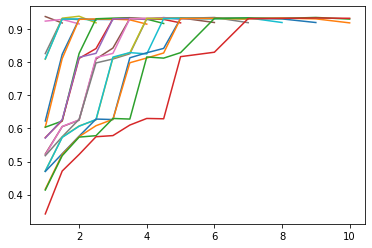

In [29]:
for label, group in df.groupby('dr'):
    #radii = (group.r_tail - group.r_head) * 2 * np.pi / group.length
    radii = 0.5 * (group.r_tail + group.r_head)

    lps = group.lp / group.length
    lps = lps[radii > 0]
    #radii = radii[radii > 0]
    radii = group.w[radii>0]/(group.w_theory[radii>0] * radii[radii>0] / group.r_head[radii>0])
    plt.plot(lps, radii)
plt.show()

In [764]:
2 * np.pi**3

62.01255336059963

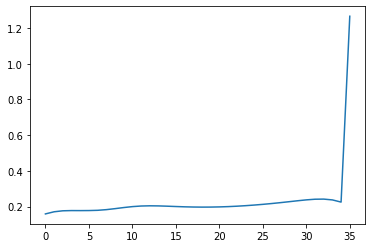

In [778]:
plt.plot(dtheta[-100, :])

2722

In [31]:
params, specs = get_params_specs(spec_hr_files[2])
print(specs.shape[0])

5000


In [32]:
r_avg = (df.iloc[2].r_head + df.iloc[2].r_tail)/2

In [33]:
params.length[0]/r_avg**2

0.7434678053066754

In [34]:
final_positions = specs['fil000'].iloc[-1].unstack()

In [35]:
x = final_positions['x']
y = final_positions['y']

In [36]:
final_positions = np.array([x.values, y.values]).transpose()

In [37]:
rs = np.diff(final_positions, n=1, axis=0)
rss = np.diff(final_positions, n=2, axis=0)
rsss = np.diff(final_positions, n=3, axis=0)
rssss = np.diff(final_positions, n=4, axis=0)

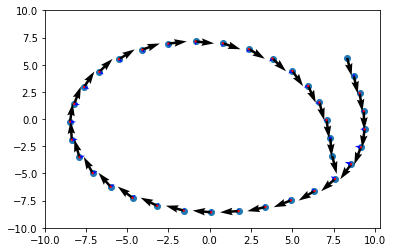

In [38]:
plt.scatter(x, y)
plt.quiver(x, y, rs[:, 0], rs[:, 1])
plt.quiver(x[1:-1], y[1:-1], rss[:, 0], rss[:, 1], color='blue', angles='xy', scale_units='xy', scale=1)
plt.quiver(x[2:-2], y[2:-2], rssss[:, 0], rssss[:, 1], color='red', angles='xy', scale_units='xy', scale=1)
plt.xlim(-10, )
plt.ylim(-10, 10)
plt.show()

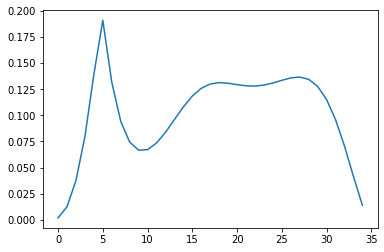

In [39]:
plt.plot(np.sum(rss**2, axis=1))

In [87]:
x = specs['fil000']['site035']['x'].iloc[-1000:].values
y = specs['fil000']['site035']['y'].iloc[-1000:].values

xp = specs['fil000']['site034']['x'].iloc[-1000:].values
yp = specs['fil000']['site034']['y'].iloc[-1000:].values

xn = specs['fil000']['site036']['x'].iloc[-1000:].values
yn = specs['fil000']['site036']['y'].iloc[-1000:].values

In [99]:
rn[0, :]

array([1.66173718, 0.12805417])

In [100]:
rn = np.array([xn - x, yn-y]).transpose()
rp = np.array([x - xp, y - yp]).transpose()
rn_mags = np.sum(rn**2, axis=1)
rp_mags = np.sum(rp**2, axis=1)
rn[:, 0] /= rn_mags
rn[:, 1] /= rn_mags
rp[:, 0] /= rp_mags
rp[:, 1] /= rp_mags

In [104]:
tangents = 0.5 * (rn + rp)

In [70]:
x = x - x.mean()
y = y - y.mean()

In [72]:
r = np.array([x, y]).transpose()

In [79]:
rlengths = np.sqrt(np.sum(r**2, axis=1))
ru = r.copy()
ru[:, 0] /= rlengths
ru[:, 1] /= rlengths

In [107]:
np.dot(tangents, ru)

ValueError: shapes (1000,2) and (1000,2) not aligned: 2 (dim 1) != 1000 (dim 0)

In [110]:
[np.dot(i, j) for i, j in zip(tangents, ru)]

[0.2390307931081252,
 0.23958231870702956,
 0.24014388414033622,
 0.24071537226247963,
 0.24129666201063282,
 0.24188762841984612,
 0.24248814264125695,
 0.2430980719633914,
 0.2437172798366099,
 0.24434562590075823,
 0.24498296601600675,
 0.24562915229694662,
 0.24628403314994934,
 0.24694745331381576,
 0.24761925390371683,
 0.24829927245844904,
 0.24898734299099942,
 0.24968329604241177,
 0.25038695873897676,
 0.25109815485268283,
 0.2518167048649612,
 0.2525424260336679,
 0.25327513246327615,
 0.25401463517826117,
 0.2547607421996077,
 0.2555132586244186,
 0.2562719867085548,
 0.2570367259522479,
 0.25780727318862795,
 0.2585834226750755,
 0.25936496618734894,
 0.26015169311636843,
 0.26094339056761495,
 0.26173984346297985,
 0.2625408346450425,
 0.2633461449836193,
 0.2641555534844735,
 0.2649688374001102,
 0.2657857723424962,
 0.26660613239758646,
 0.2674296902415592,
 0.26825621725857784,
 0.26908548365999385,
 0.2699172586048023,
 0.2707513103212499,
 0.2715874062294105,
 0.2724

In [67]:
specs['fil000']['site036']['y'].iloc[-1000:].mean()

-0.07328502570666728

In [66]:
specs['fil000']['site036']['x'].iloc[-1000:].mean()

0.7352191418266479

In [805]:
# Continuum bending energy
np.sum(np.sum((rss)**2, axis=1))

3.5427193626935782

In [806]:
rs_mags = np.sqrt(np.sum(rs**2, axis=1))
norm_rs = np.array([rs[:, 0] / rs_mags, rs[:, 1] / rs_mags]).transpose()

In [752]:
# Discrete bending energy
thetas = np.array([np.arccos(np.dot(norm_rs[i, :], norm_rs[i+1, :])) for i in range(norm_rs.shape[0]-1)])
d_thetas = np.diff(thetas)
(d_thetas**2/params.bond_length[0]).sum()

0.012516883808876268

In [810]:
specs = list(Path('./data/spiral_results/').glob('test*spec'))

In [811]:
# from simcore_tools import SpecReader, get_params_specs

In [812]:
# sreader = SpecReader(specs[0])
# sreader.make_human_readable()

In [813]:
# params, specs = sreader.get_params_specs()

In [814]:
params, specs = get_params_specs('data/spiral_results/test_spiral_filament_mt.spec.hr')

In [815]:
final_positions = specs['fil000'].iloc[-1].unstack()

In [816]:
x = final_positions['x']
y = final_positions['y']

In [817]:
final_positions = np.array([x.values, y.values]).transpose()

In [818]:
rs = np.diff(final_positions, axis=0)
rss = np.diff(rs, axis=0)
rsss = np.diff(rss, axis=0)
rssss = np.diff(rsss, axis=0)

(0, 25)

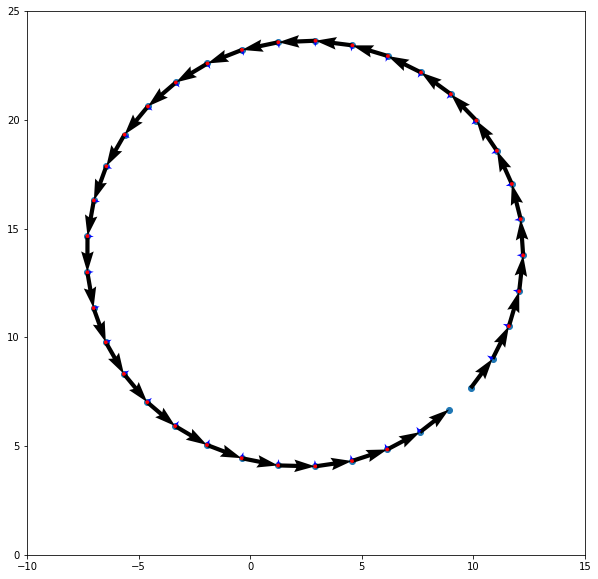

In [819]:
plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.quiver(x[:-1], y[:-1], rs[:, 0], rs[:, 1], angles='xy', scale_units='xy', scale=1)
plt.quiver(x[1:-1], y[1:-1], rss[:, 0], rss[:, 1], color='blue', angles='xy', scale_units='xy', scale=1)
plt.quiver(x[2:-2], y[2:-2], rssss[:, 0], rssss[:, 1], color='red', angles='xy', scale_units='xy', scale=1)
#plt.xlim(-15, 15)
#plt.ylim(0, 30)
plt.xlim(-10, 15)
plt.ylim(0, 25)

In [820]:
# Continuum bending energy
np.sum(np.sum((rss)**2, axis=1))

2.8639447205868573

In [821]:
rs_mags = np.sqrt(np.sum(rs**2, axis=1))
norm_rs = np.array([rs[:, 0] / rs_mags, rs[:, 1] / rs_mags]).transpose()

In [822]:
# Discrete bending energy
thetas = np.array([np.arccos(np.dot(norm_rs[i, :], norm_rs[i+1, :])) for i in range(norm_rs.shape[0]-1)])
d_thetas = np.diff(thetas)
(d_thetas**2/params.bond_length[0]).sum()

2.897562801875578e-06

In [823]:
u = norm_rs

In [824]:
forces = np.array([np.matmul((np.eye(2) - np.outer(u[i+1, :], u[i+1, :])), u[i, :])
 + np.matmul((np.eye(2) - np.outer(u[i, :], u[i, :])), u[i+1, :])
 - np.matmul((np.eye(2) - np.outer(u[i-1, :], u[i-1, :])), u[i, :])
    for i in range(1, u.shape[0]-1)])

In [825]:
np.sqrt(np.sum(forces**2, axis=1)).sum()

5.639517689549308

In [1]:
3.5/2.8

1.25

In [4]:
4*3.14159*1.25

15.70795

In [115]:
8 * np.pi**3/60 * np.sqrt(1+2*np.pi**2)

18.82714410429388

In [116]:
0.38*60

22.8

In [118]:
4 * np.pi**2/60 * np.sqrt(1 + 60**2/(2.5)**2)

15.805068881233344

In [119]:
np.sqrt(1 + 60**2/(2.5)**2)

24.020824298928627